# Summary Notebook:  HEASARC access through python
In this notebook, we go through a number of examples of accessing HEASARC data (including catalogs, images and spectra) for a specific science case using various VO protocols. This notebook presents the broad summary of available protocols. We also offer specific notebooks for these topics:  [SCS](heasarc_Cone_Search.ipynb), [SIA](heasarc_Image_Access.ipynb), [SSA](heasarc_Spectral_Access.ipynb), [TAP](heasarc_TAP_queries.ipynb), and [VOTables](heasarc_VO_Tables.ipynb).  

**Sample science case**: we would like to prepare an observing proposal to target a sample of potentially interacting galaxies. There is some evidence that these types of galaxies have a higher frequency of ultraluminous X-ray binaries, and we would like to test this hypothesis in our study. Therefore, we will upload our sample list, make images, cross-correlate with HEASARC catalogs to get additional information, and produce a spectrum. 

The various services are described on the <a href="https://heasarc.gsfc.nasa.gov/docs/archive/vo/">HEASARC VO page</a>. In summary:

* <a href="#votable">1. VOTable</a>: <a href="#votable">Accessing</a> and <a href="#votable">creating</a> VOTables
* <a href="#scs">2. SCS</a>:  Using the Simple Cone Search to query individual catalogs in a loop
* <a href="#sia">3. SIA</a>: Using the Simple Image Access protocol to find images of interest 
* <a href="#tap">4. TAP</a> Using the Table Access Protocol (TAP)
 * <a href="#tap1">4a. TAP1</a>: Using the Table Access Protocol to find available VO resources
 * <a href="#tap2">4b. TAP2</a>: Using the TAP to cross-correlate our objects with a catalog of objects
 * <a href="#combo">4c. Combining data</a> from different catalogs
* <a href="#ssa">5. SSA</a> :  Using the Simple Spectral Access protocol to retrieve spectra.


## Notes:

There are a number of ways to use VO services through Python. There is as yet no single standardized set of Python tools for accessing VO data. From the AstroQuery web page (https://astroquery.readthedocs.io/en/latest/):

<div class="alert alert-block alert-info">"There are two other packages with complimentary functionality as Astroquery: astropy.vo is in the Astropy core and pyvo is an Astropy affiliated package. They are more oriented to general virtual observatory discovery and queries, whereas Astroquery has web service specific interfaces."</div>
    
Since the queries we generate are fairly basic, we will use the general python ``requests`` package to submit queries to the various VO services. Using ``requests`` has the benefit of not requiring installation of more specialized packages. 
  


In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy
## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")
## The main HTTP request tool we will use:
import requests
## For simple astropy tables
import astropy
import io
from IPython.display import Image, display

## For handling ordinary astropy Tables
from astropy.table import Table

## For handling VO table type objects
from astropy.io import votable as apvot

## For reading FITS files
import astropy.io.fits as apfits

<a id="votable"></a>
# 1. VOTable:  working with VO Table objects


The __[IVOA TAP document](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ describes the Table Access Protocol (TAP) that consist of an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what you wish to search for. 

In this example, we show how to list, fetch and look at VO tables from the HEASARC archive and also how to create your own VO Table, which can be used to cross-correlate with other VO Tables (see examples [4a](#tap1) and [4b](#tap2) below). 

See the notebook dedicated to [Using VOTables](heasarc_VO_Tables.ipynb) for more details.



<a id="votable1"></a>

## 1.1 Retrieving a catalog as a VO Table

We can use W3Browse to get a HEASARC catalog as a VOTable object.  W3Browse can be used to retrieve tables in a number of formats, one of which is a VO Table.  

The python ``requests`` package is a generic interface to web services.  The requests.get() method formats the given parameters for you and returns the results of the HTTP request in a useful object.  In this case, the result is a string containing the VOTable result.  The standard ``astropy.table`` package can read these.

So here, we'll retrieve the ``rosmaster`` catalog, which has 11k lines, and just look at the first 5:

In [2]:
params = {'name': 'rosmaster'}
r = requests.get('http://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/getvotable.pl', params=params)

In [3]:
table=Table.read(io.BytesIO(r.content))

In [4]:
#table.show_in_notebook(display_length=11) # print only the first 11 of the 11k rows.
table[:11]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28
,deg,deg,deg,deg,,,,s,s,,MJD,MJD,,,,,,,,,,,,deg,d,d,
str16,float64,float64,float64,float64,str6,str2,str4,int32,int32,str10,float64,float64,str20,str16,str14,int32,str4,int16,int16,str120,int32,int16,int32,int16,int32,int32,int16
RH202299N00,49.3200,-85.5400,299.8517,-30.6815,HRI,N,MPE,36146,70000,RDF 4_2,50174.496192129598,50187.986747685201,RE J0317-853,BURLEIGH,MATTHEW,202299,n00,2,2,RE J0317-853,24302,6,7128,307,2163,2177,2900
RH202299A01,49.3200,-85.5400,299.8517,-30.6815,HRI,N,MPE,43683,70000,RDF 3_6,50324.742534722202,50377.477592592601,RE J0317-853,BURLEIGH,MATTHEW,202299,a01,2,2,RE J0317-853,24301,6,7128,162,2316,2369,2900
RP200594N00,151.8800,-85.0800,299.4192,-23.3707,PSPCB,N,MPE,4231,5000,RDF 3_4,48682.1389583333,48690.983333333301,HD 89499,FLEMING,THOMAS,200594,n00,2,2,HD 89499,17171,2,3532,66,648,657,2900
RH201328N00,107.9100,-84.4700,296.7740,-26.5072,HRI,N,MPE,2332,2000,RDF 3_4,48880.838020833296,48881.780729166698,HD 60102 AB,ZINNECKER,HANS,201328,n00,2,2,HD 60102 AB,22560,3,4268,215,850,851,2900
RH400876A01,193.9400,-83.3700,303.0651,-20.4994,HRI,N,GSFC,19075,20000,RDF 4_2,50702.423530092601,50735.172557870399,2EG J1248-8306 POS 3,HALPERN,JULES,400876,a01,4,2,2EG J1248-8306 POS 3,25116,7,2460,299,2699,2733,9999
RH400876N00,193.9400,-83.3700,303.0651,-20.4994,HRI,N,GSFC,1059,20000,RDF 4_0,50548.2425,50548.255474537,2EG J1248-8306 POS 3,HALPERN,JULES,400876,n00,4,2,2EG J1248-8306 POS 3,19808,7,2460,85,2543,2543,9999
RH400877A02,190.1700,-83.3600,302.6001,-20.4952,HRI,N,GSFC,19384,20000,RDF 4_2,50893.248460648101,50895.138969907399,2EG J1248-8306 POS 4,HALPERN,JULES,400877,a02,4,2,2EG J1248-8306 POS 4,24927,7,2460,90,2893,2895,9999
RH400877A01,190.1700,-83.3600,302.6001,-20.4952,HRI,N,GSFC,2363,20000,RDF 4_2,50735.5647916667,50735.574120370402,2EG J1248-8306 POS 4,HALPERN,JULES,400877,a01,4,2,2EG J1248-8306 POS 4,25115,7,2460,260,2733,2733,9999


<a id="votable2"></a>
## 1.2 Creating a VO Table from scratch

Alternatively, we can create a table from scratch using an array of values.  

There are several ways of doing this, and there are a few object layers here, which can be confusing.  There are standard astropy Table objects, there are votable Table objects, and there are votable VOTableFile objects that might contain multiple votable Tables. Though some things can be done with generic astropy Tables, other VO operations can only be done with VO Tables or VOTableFile objects.  

This is easiest to see in an example. In the following we create an astropy Table of RA and Dec values:

In [5]:
##  Create a table with only two columns starting from an astropy Table:  
from astropy.table import Table as apTable
aptable=apTable(
    numpy.array([
            [19.0186,       46.7304],
            [20.2887,       40.4703],
            [125.886,       21.3377],
            [136.002,       21.9679],
            [141.057,       40.6372],
            [146.700,       22.0116],
            [148.785,       14.2922],
            [149.751,       17.8168],
            [175.039,       15.3270],
            [191.542,       30.7317],
            [194.913,       28.8959],
            [199.026,       41.5011],
            [206.577,       43.8511],
            [209.963,       38.1821],
            [213.556,       15.6214],
            [219.967,       42.7421],
            [226.693,       12.8502],
            [237.489,       20.8057],
            [241.519,       20.8014],
            [317.088,       18.2002],
            [329.235,       6.64845],
            [333.830,       37.3012] ]), 
    names=["RA","DEC"])
print("Table type is {ttype}".format(ttype=type(aptable)))
aptable['RA'].format=".4f"
aptable['DEC'].format=".4f"
aptable.show_in_notebook()



Table type is <class 'astropy.table.table.Table'>


idx,RA,DEC
0,19.0186,46.7304
1,20.2887,40.4703
2,125.8860,21.3377
3,136.0020,21.9679
4,141.0570,40.6372
5,146.7000,22.0116
6,148.7850,14.2922
7,149.7510,17.8168
8,175.0390,15.3270
9,191.5420,30.7317


## 1.3 Converting to a VOTableFile instance

In [6]:
## Then convert this to a VOTableFile object.
votablefile = apvot.from_table(aptable)
print(type(votablefile))
## Which contains a nested set of RESOURCES
for r in votablefile.resources:
    ## And tables (in this case, only one of each)
    mytable=r
    for t in r.tables:
        print(type(t))
        print(t)


<class 'astropy.io.votable.tree.VOTableFile'>
<class 'astropy.io.votable.tree.Table'>
        RA                DEC        
------------------ ------------------
19.018599999999999 46.730400000000003
20.288699999999999 40.470300000000002
           125.886 21.337700000000002
136.00200000000001            21.9679
141.05699999999999            40.6372
146.69999999999999 22.011600000000001
           148.785 14.292199999999999
           149.751 17.816800000000001
175.03899999999999             15.327
           191.542            30.7317
194.91300000000001 28.895900000000001
199.02600000000001 41.501100000000001
           206.577 43.851100000000002
209.96299999999999 38.182099999999998
213.55600000000001            15.6214
219.96700000000001 42.742100000000001
226.69300000000001 12.850199999999999
           237.489 20.805700000000002
241.51900000000001 20.801400000000001
317.08800000000002 18.200199999999999
329.23500000000001 6.6484500000000004
333.82999999999998 37.301200000000001


<a id="scs"></a>
# 2. SCS:  Using the Simple Cone Search to query a different catalog in a loop
The __[Simple Cone Search (SCS) protocol](http://www.ivoa.net/documents/latest/ConeSearch.html)__ is used to search a given table with a given position and radius, getting again a VOTable XML result.  See also the notebook on [using SCS](heasarc_Cone_Search.ipynb) for more details.  

In our science example, <i> we might want to search for available information for the source in the table created above in different HEASARC catalogs.</i> For example, suppose we were considering proposing for observing time with Chandra. Let's check first to see whether any of our sources were already observed by Chandra, XMM or ROSAT. 

Below, we show the search of the table 'chanmaster', the master catalog of observed Chandra targets, with a search radius of 0.1 degrees. 

<a id="scs1"></a>
The SCS protocol is quite straightforward.  The ``params`` dictionary should specify the ``RA`` and ``Dec`` for the source of interest, a search radius ``SR`` in degrees, along with the ``table`` to be queried.  An example is shown below where we loop through the first five positions specified in our source table (``aptable``) created above

In [7]:
SR=0.1
for row in aptable[:5]:
    params = {'table': 'chanmaster', 'RA': row['RA'], 'DEC':row['DEC'], 'SR':SR}
    r = requests.get('https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl', params=params)
    table=Table.read(io.BytesIO(r.content))
    print "Source RA, Dec =({ra}, {dec})".format(ra=row['RA'], dec=row['DEC'])
    if len(table) > 0:
        #print "Source RA, Dec =({ra}, {dec})".format(ra=row['RA'], dec=row['DEC'])
        print(table['obsid','status','ra','dec','exposure','Search_Offset'])
        print("\n")
    else:
        #print "Source RA, Dec =({ra}, {dec})".format(ra=row['RA'], dec=row['DEC'])
        print("No Chandra Observation within {sr} degrees".format(sr=SR))
        print("\n")
print "End of Chanmaster Search\n"
    

Source RA, Dec =(19.0186, 46.7304)
No Chandra Observation within 0.1 degrees


Source RA, Dec =(20.2887, 40.4703)
No Chandra Observation within 0.1 degrees


Source RA, Dec =(125.886, 21.3377)
obsid  status      ra      dec    exposure Search_Offset
                  deg      deg       s                  
----- -------- --------- -------- -------- -------------
 7937 archived 125.81833 21.38608    30030        4.7670


Source RA, Dec =(136.002, 21.9679)
No Chandra Observation within 0.1 degrees


Source RA, Dec =(141.057, 40.6372)
No Chandra Observation within 0.1 degrees


End of Chanmaster Search



<a id="sia"></a>
# 3. SIA:  Using the Simple Image Access protocol.


The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the SIA protocol. See also the dedicated notebook on [using SIA](heasarc_Image_Access.ipynb).  

But first, how do you know what sorts of images are available?

## 3.1:  Finding SkyView SIA resources from the NAVO directory with TAP

SIA resources available through SkyView are listed in a registry at STScI which we can access through the __[IVOA Table Access Protocol](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ (TAP). We submit an HTTP request to a given TAP service URL formed in a particular language ([ADQL](http://www.ivoa.net/documents/ADQL/2.0) in this case) to specify what we wish to search for, in this case the HEASARC SIA resources: 

### !!!Not obvious how this query is constructed, or what a user would need to do to convert it to another search if needed.

Can we add some notes to explain what the various query statements mean, and how they're defined?

In [8]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,a.ivoid from rr.capability a 
        natural join rr.resource b 
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
##  If you want to see what requests gives you, you can look at the URL it actually constructed:
#print(r.url)
##  And the raw text of what it got back:
# print(r.text)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
table=Table.read(io.BytesIO(r.content))
table.show_in_notebook()

idx,short_name,ivoid
0,1420MHz,ivo://nasa.heasarc/skyview/1420mhz
1,2MASS,ivo://nasa.heasarc/skyview/2mass
2,408MHz,ivo://nasa.heasarc/skyview/408mhz
3,AKARI,ivo://nasa.heasarc/skyview/akari
4,ASCA,ivo://nasa.heasarc/ascamaster
5,ASCA/AGN,ivo://nasa.heasarc/tartarus
6,ASCASIS,ivo://nasa.heasarc/ascasis
7,BAT-flux-1,ivo://nasa.heasarc/skyview/bat-flux-1
8,BATSIG,ivo://nasa.heasarc/skyview/batsig
9,CDFS-LESS,ivo://nasa.heasarc/skyview/cdfs-less


### 3.2 Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, SwiftUVOT, and look for our sources.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of ``rows,columns``.  (SkyView will bin/interpolate as needed from the archive data.)  

In [9]:
pos='{},{}'.format(aptable[0]['RA'],aptable[0]['DEC'])
#  Note that there's currently a bug in the default interpolation 
#  method with this particular query, so we have to set it to 'LI' here.
params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.03', "NAXIS":"300,300"}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
table=Table.read(io.BytesIO(r.content))
print(table.colnames)

['Survey', 'Ra', 'Dec', 'Dim', 'Size', 'Scale', 'Format', 'PixFlags', 'URL', 'LogicalName']


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [11]:
table['Ra'].format='.4f'
table['Dec'].format = '.4f'
table.show_in_notebook(display_length=5)

idx,Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
0,swiftuvotvint,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074068436&return=FITS,1
1,swiftuvotvint,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074068436&nofits=1&quicklook=jpeg&return=jpeg,1
2,swiftuvotbint,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074068698&return=FITS,2
3,swiftuvotbint,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074068698&nofits=1&quicklook=jpeg&return=jpeg,2
4,swiftuvotuint,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074069911&return=FITS,3
5,swiftuvotuint,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074069911&nofits=1&quicklook=jpeg&return=jpeg,3
6,swiftuvotuvw1int,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074070423&return=FITS,4
7,swiftuvotuvw1int,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074070423&nofits=1&quicklook=jpeg&return=jpeg,4
8,swiftuvotuvw2int,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074070946&return=FITS,5
9,swiftuvotuvw2int,19.0186,46.7304,2,[300 300],[-9.999999999999999e-05 9.999999999999999e-05],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074070946&nofits=1&quicklook=jpeg&return=jpeg,5


In [12]:
###  Inside the table is a numpy record array that you can access like this, for example:
#print(table.array[4][8])
#  Or like this
print(table[4]['URL'])
### To download the FITS image itself:
print(table[5]['URL'])

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074069911&return=FITS
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1515074069911&nofits=1&quicklook=jpeg&return=jpeg


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


In [13]:
##  Note that there are bugs with some of these datasets, 
##  since they are new in SkyView.  Selecting the U-band image.
##  (The decode is needed in Python 3.5 because it comes back a byte type.)
display(Image(url=table['URL'][5].decode("utf-8")))

Or download the FITS image as ``image.fits``


In [14]:
r=requests.get(table['URL'][4].decode("utf-8"), stream=True)
with open('image.fits','wb') as f:
    f.write(r.content)

(If the above gives you a "time out" error, just try it again.)

Then read the fits image you just created and display it:

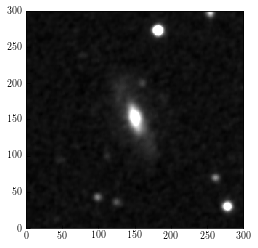

In [15]:
#hdu_list=apfits.open(table['URL'][4].decode("utf-8"))
hdu_list=apfits.open('image.fits')
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

### Alternatively, we can use Aplpy to make an image with coordinates

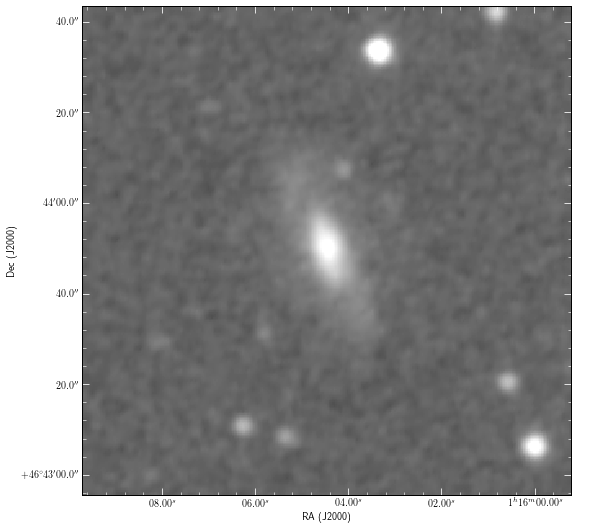

In [16]:
import aplpy
gc = aplpy.FITSFigure(hdu_list)
gc.show_grayscale(stretch='log', vmin=6e-3, vmax=1.4e-1)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at the Barbara A. Mikulski Archive for Space Telescopes ([MAST](https://mast.stsci.edu)).  The user does not need to be aware of where the data is actually stored - under the hood, SkyView is using SIA to get the data from MAST transparently.  


In [17]:
params['survey']='sdssg'
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)

(It may take a few seconds for the displyed image to appear.)

In [18]:
table=Table.read(io.BytesIO(r.content))
display(Image(url=table['URL'][1].decode("utf-8")))

<a id="tap"></a>
# 4. TAP: Using the Table Access Protocol to find VO Resources

<a id="tap1"></a>
# 4a. TAP:  Using the Table Access Protocol to find additional information on our sources
TAP is described in more detail in the dedicated [TAP notebook](heasarc_TAP_queries.ipynb).

In this example, we will use our tabulated list of 22 sources (``aptable``) we create above.  <i> Continuing with our hypothetical science example of preparing an observing proposal for these objects, we would now like to find their redshifts, e.g., to calculate exposure times based on being able to significantly detect a 10<sup>39</sup> erg/s source.</i>

First, find out what catalogs HEASARC holds that might have redshifts, specifying the query in ADQL:

In [19]:

tap_params["query"]="""
    select a.name,b.value
      from metainfo a, metainfo b
      where
         a.type='table' and b.type='table' and
         a.relation='defaultSearchRadius' and
         b.relation='description' and
         a.name=b.name and
         b.value like '%Redshift%' 
      order by name    
      """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
table=Table.read(io.BytesIO(r.content))
table.show_in_notebook()

idx,name,value
0,abellzcat,Abell Clusters Measured Redshifts Catalog
1,atlasspecz,AT Large Area Survey (ATLAS) Spectroscopic Classes & Redshifts Catalog
2,ccosmphotz,Chandra COSMOS (C-COSMOS) Survey Photometric Redshift Catalog
3,cfa2s,CfA Redshift Survey: South Galactic Cap Data
4,iraspscz,IRAS Point Source Catalog Redshift (PSCz) Catalog
5,iraszsurv,IRAS 1.2-Jy Redshift Survey
6,lcrscat,Las Campanas Redshift Survey Catalog
7,lowzvlqvla,VLA 6-GHz Observations of Low-Redshift SDSS QSOs
8,planckhzsc,Planck High-Redshift Source Candidates Catalog
9,sixdfgs,6dFGS Galaxy Survey Final Redshift Release Catalog


Of all the tables with redshift information, probably the ``CfA Redshift Catalog`` (``zcat``) is best for our purposes.  <i> Since these are galaxies found in close pairs or groups, we expect multiple matches at each location. </i> Let's first start with one object and search within 0.1 degree: 

In [20]:
##  Pick a radius in degrees to search around our input coordinates:
radius=0.1

query = """SELECT ra, dec, Radial_Velocity FROM zcat as cat where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{0},{1},{2}))=1
    """.format(aptable[0]['RA'],aptable[0]['DEC'],radius)
print(query)

tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"{q}".format(q=query)
    }
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
#r.content
table=Table.read(io.BytesIO(r.content))
table['ra'].format='.4f'
table['dec'].format='.4f'
table.show_in_notebook()

SELECT ra, dec, Radial_Velocity FROM zcat as cat where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',19.0186,46.7304,0.1))=1
    


idx,ra,dec,radial_velocity
0,19.0098,46.7304,-1
1,19.0684,46.7400,5081
2,19.0864,46.7472,5188


### !!! in the above query, how do we know we should return "Radial_Velocity" and not "Redshift"?  i.e. how does the user know that, for zcat, the Redshift parameter is called Radial_Velocity (and given in, presumably, km/s)?

<a id="tap2"></a>
# 4b. TAP:  Cross-correlating our objects with a catalog

Now to search all of our 22 sources in ``aptable`` in one go, we need to upload ``aptable`` as a VOTable file instance to the VO service ``https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync`` and do a cross-correlation with the ``zcat``table. 

In Section 1.3 above we had already created a VOTableFile instance called ``votablefile`` from our ``aptable``. Now we need to use the ``requests`` method to upload this ``votablefile`` and use it in our TAP request.

First, create a "file-like" object from ``votablefile`` that you can give to ``requests``.  This is a bit arcane:

In [21]:
vot_obj=io.BytesIO() # Create a file-like IO stream in memory
apvot.writeto(votablefile,vot_obj) # write the VOTable to this file-like stream
vot_obj.seek(0) # make sure you've reset seek to beginning of buffer
## 'uplt' is what we'll call it (for 'upload table') 
##   in the requests parameters below, or what you will:
files={'uplt':vot_obj}

Alternatively, you could have written ``votablefile`` to disk:
```
apvot.writeto(votablefile, "new_votable.xml")
files={'uplt':open('new_votable.xml', 'rb')}
```

In [22]:
# NOTE THAT THIS request may take tens of seconds to complete

## The parameters below are defined in the TAP standard.  
##  The string 'uplt' is what we set above as the name
##  of the parameter containing this data, and
##  the string 'mysources' is how we refer to it in 
##  the ADQL query string:
cc_params={
    'lang': 'ADQL', 
    'request': 'doQuery',
    'upload':'mysources,param:uplt'
    }
# Define the query to cross-correlate each item in our list of source positions 
#   with zcat to find the radial velocities of the sources
cc_params["query"]="""
    SELECT cat.ra, cat.dec, Radial_Velocity 
    FROM zcat cat, tap_upload.mysources mt 
    WHERE
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,0.1))=1
    and Radial_Velocity > 0
    ORDER by cat.ra"""
# Send the request 
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,stream=True,files=files)
mytable=Table.read(io.BytesIO(r.content))
mytable['ra'].format='.4f'
mytable['dec'].format='.4f'
mytable.show_in_notebook(display_length=10)

idx,ra,dec,radial_velocity
0,19.0684,46.7400,5081
1,19.0864,46.7472,5188
2,20.3348,40.4877,5859
3,125.9044,21.3382,5219
4,125.9044,21.3382,5364
5,135.9942,21.9010,3157
6,136.0007,21.9679,3093
7,141.0915,40.6838,8267
8,146.7033,22.0183,7446
9,146.7033,22.0183,7597


### !!! If I'm understanding correctly, in mytable above the RAs and Decs given are not the RAs and Decs of the 22 sources specified in aptable, but rather the RAs and Decs of the nearest matching source in zcat - is that right?  

### !!! I think a user would instead want the RA and Dec of the source from aptable, the RA and Dec of the nearest matching source in zcat, the source offset and the radial_velocity.  One way to do this would be, for each source in aptable, find the nearest source in mytable, extract it's ra, dec, radial_velocity and offset, and add that info as new columns in aptable.

If that's right, I THINK you can do it as the following cell shows:

In [23]:
from astropy import units as u
from astropy.coordinates import SkyCoord

capt = SkyCoord(aptable['RA']*u.degree, aptable['DEC']*u.degree)
cmyt = SkyCoord(mytable['ra']*u.degree, mytable['dec']*u.degree)
# use match_to_catalog method to match aptable sources with the nearest catalogued sources
idx, d2d, d3d = capt.match_to_catalog_sky(cmyt)  

# create new table
newaptable=aptable.copy()
radvel = mytable[idx]['radial_velocity']
newaptable['radvel']=radvel
newaptable['ra_match']=mytable[idx]['ra']
newaptable['dec_match']=mytable[idx]['dec']
newaptable['offset']=d2d.to(u.arcmin)
newaptable['ra_match'].format='.4f'
newaptable['dec_match'].format='.4f'
newaptable['offset'].format='.3f'
newaptable.show_in_notebook()

idx,RA,DEC,radvel,ra_match,dec_match,offset
,,,,,,arcmin
0,19.0186,46.7304,5081,19.0684,46.7400,2.128
1,20.2887,40.4703,5859,20.3348,40.4877,2.349
2,125.8860,21.3377,5364,125.9044,21.3382,1.031
3,136.0020,21.9679,3093,136.0007,21.9679,0.070
4,141.0570,40.6372,8267,141.0915,40.6838,3.206
5,146.7000,22.0116,7597,146.7033,22.0183,0.441
6,148.7850,14.2922,7194,148.7781,14.2961,0.468
7,149.7510,17.8168,7182,148.8031,14.3127,217.229
8,175.0390,15.3270,3325,175.0394,15.3273,0.028


<a id="combo"></a>

# 4c. Another example with TAP table cross-correlation: Combining data from different catalogs
Now we'd like to take the redshift information (above, as a radial velocity) and determine a search radius to use for each galaxy based on its distance, so that we are are searching within a given physical distance. <i>E.g., for our science proposal, we need to check that the redshifts (or radial velocities) of the galaxies that are close on the sky (within 50 kpc physical distances) have similar distances, suggesting these are truly close in 3-dimensions and therefore potentially interacting galaxies.</i>

### !!! instead of using the above cell with mytable, use newaptable as shown below


In [26]:
## The radial_velocity is in km/s, and this is just c*z, so
c=3.0e5 # km/s

newaptable['redshift']=newaptable['radvel']/c  # Filling masked values with zero

physdist=0.05*u.Mpc # 50 kpc physical distance

## This needs scipy.  
from astropy.cosmology import Planck15

angDdist=Planck15.angular_diameter_distance(newaptable['redshift'])

## angDdist is returned from the astropy.cosmology module as a Quantity object, 
##  i.e. a value and a unit.  Arctan is smart enough not to operate on quantities
##  that aren't unitless.  So angDdist.value to just get the value.
angDrad=numpy.arctan(physdist/angDdist)
angDdeg=angDrad.to(u.degree)
newaptable['angDdeg']=angDdeg
newaptable['RA'].format='.4f'
newaptable['DEC'].format='.4f'
newaptable['redshift'].format='.3f'
newaptable['angDdeg'].format='.2e'
newaptable.show_in_notebook()

idx,RA,DEC,radvel,ra_match,dec_match,offset,redshift,angDdeg
,,,,,,arcmin,,deg
0,19.0186,46.7304,5081,19.0684,46.7400,2.128,0.017,3.90e-02
1,20.2887,40.4703,5859,20.3348,40.4877,2.349,0.020,3.39e-02
2,125.8860,21.3377,5364,125.9044,21.3382,1.031,0.018,3.70e-02
3,136.0020,21.9679,3093,136.0007,21.9679,0.070,0.010,6.36e-02
4,141.0570,40.6372,8267,141.0915,40.6838,3.206,0.028,2.43e-02
5,146.7000,22.0116,7597,146.7033,22.0183,0.441,0.025,2.64e-02
6,148.7850,14.2922,7194,148.7781,14.2961,0.468,0.024,2.78e-02
7,149.7510,17.8168,7182,148.8031,14.3127,217.229,0.024,2.78e-02
8,175.0390,15.3270,3325,175.0394,15.3273,0.028,0.011,5.92e-02


<a id="ssa"></a>
# 6. SSA:  Using the Simple Spectral Access protocol to retrieve spectra.

See also the [notebook](heasarc_Spectral_Access.ipynb) specific to the Simple Spectral Access __[Protocol](http://www.ivoa.net/documents/SSA/)__.

<i>Returning to our science example, suppose that we have analyzed the available Chandra image for the three matches above and discovered that one of these galaxies appears to have a potential ultraluminous X-ray source (ULX)! Now, we want to charatcterize the spectrum for this source. Therefore we will ask for a large exposure time and need to justify this by showing the spectrum of a prototypical ULX, M82 X-1. </i>


In [27]:
import astropy.coordinates as coord
m82=coord.SkyCoord.from_name("m82")
pos='{},{}'.format(m82.ra.deg,m82.dec.deg)
params = {'table': 'chanmaster',"POS":pos,"SIZE":".01", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
spec_table = Table.read(io.BytesIO(r.content))
spec_table.show_in_notebook()

idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_datalength,SSA_datamodel,SSA_title,SSA_instrument,SSA_publisher,SSA_tmid,SSA_stop_time,SSA_start_time,SSA_duration,SSA_bandpass,SSA_wavelength_max,SSA_wavelength_min,SSA_bandwidth,SSA_ra,SSA_dec,SSA_coord_obs,SSA_fov,SSA_reference,SSA_format
,,,,deg,deg,mjd,,,s,,,mjd,,,,,,mjd,mjd,mjd,s,meter,meter,meter,meter,deg,deg,deg,deg,,
0,17860,archived,M82 X-1,148.95917,69.67972,57639.729200000002,ACIS-S,HETG,51060,TOO,Walton,58010,12.0,Spectrum-1.0,acisf17860N002_pha2,ACIS-S,HEASARC,57640.040393247451,57640.350814633915,57639.729200000002,51060.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/17860/primary/acisf17860N002_pha2.fits.gz,application/fits
1,19791,archived,M82 X-1,148.95917,69.67972,57641.570200000002,ACIS-S,HETG,15310,TOO,Walton,58010,12.0,Spectrum-1.0,acisf19791N002_pha2,ACIS-S,HEASARC,57641.668022753758,57641.765065583451,57641.570200000002,15310.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19791/primary/acisf19791N002_pha2.fits.gz,application/fits
2,19792,archived,M82 X-1,148.95917,69.67972,57642.353000000003,ACIS-S,HETG,32440,TOO,Walton,58010,12.0,Spectrum-1.0,acisf19792N002_pha2,ACIS-S,HEASARC,57642.558369954859,57642.762945849187,57642.353000000003,32440.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19792/primary/acisf19792N002_pha2.fits.gz,application/fits


In [28]:
## Get the first spectrum (since it has a long-ish exposure.)
import astropy.io.fits as fits
hdu_list=fits.open(spec_table[0]['SSA_reference'].decode()) # Byte format, so just decode() to string
#hdu_list.info()
table = Table(hdu_list[1].data)
table.show_in_notebook()


idx,SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
0,1,-3,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
1,2,-2,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
2,3,-1,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
3,4,1,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
4,5,2,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
5,6,3,1,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
6,7,-3,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,13.985 .. 0.333333333333,13.9866666667 .. 0.335
7,8,-2,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,20.9775 .. 0.5,20.98 .. 0.5025
8,9,-1,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005
9,10,1,2,1,4103.92,4072.69,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005


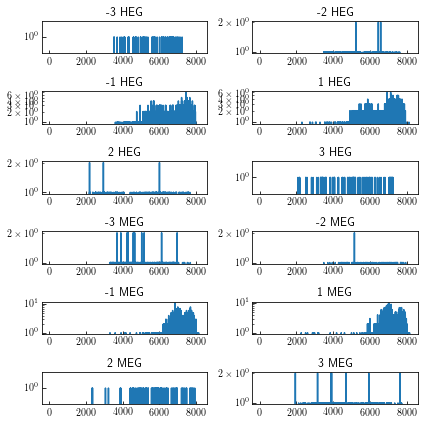

In [29]:
## Here, you just have to be familiar with the format of these spectra by reading Chandra documentation.
for i in range(len(table)):
    matplotlib.rcParams['figure.figsize'] = (6, 6)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( table['CHANNEL'][i],table['COUNTS'][i])
    ax.set_yscale('log')
    if table['TG_PART'][i] == 1:
        instr='HEG'
    if table['TG_PART'][i] == 2:
        instr='MEG'
    if table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title(str(table['TG_M'][i])+' '+instr)
    plt.tight_layout()


Note: The 12 plots here show all the different HEG and MEG components (+/- 3, +/- 2, and +/- 1 for each grating) for the grating data, as titled. In practice, you might want to download the fits file and use a different analysis and plotting tool to create an energy spectrum plot using SHERPA or XSPEC, etc. 

You can download the file directly using requests:

In [30]:
## Because urllib is hard to make Python 2/3 compatible, just use requests:
r=requests.get(spec_table[0]['SSA_reference'].decode(), stream=True)
with open('my_M82_spectrum.fits','wb') as f:
    f.write(r.content)

You can then run Xspec etc. to analyze the spectrum. See the [SSA notebook](heasarc_Spectral_Access.ipynb) for that example. 